<a href="https://colab.research.google.com/github/noabatelmoshe12/Tutorial_DataAnalysis_DecisionMaking/blob/master/Teacher_student_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
N = 100
TRAIN_SIZE = 5000
MIN_FREQ = 0
MAX_FREQ = 10
MIN_PHASE = 0
MAX_PHASE = 2 * np.pi
SEQUENCE_LENGTH = 200

# Hyperparameters
LEARNING_RATE = 0.01
BATCH_SIZE = 32
EPOCHS = 1000

In [4]:
def normal_rnn(std):
  rnn = nn.RNN(input_size=N, hidden_size=N, num_layers=1)
  for weight in rnn.all_weights[0]:  # [0] because we have a single layer
    weight.data.normal_(mean=0.0, std=std)
  return rnn

In [5]:
class Teacher(nn.Module):
  def __init__(self, std):
    super().__init__()
    self.rnn = normal_rnn(std)

  def forward(self, x):
    activity, _ = self.rnn(x)
    return activity

In [6]:
class SineWaveDataset(Dataset):
    def __init__(self, num_samples, seq_length, teacher_std, freq_interval, phase_interval):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.freq_interval = freq_interval
        self.phase_interval = phase_interval
        self.amplitude_vector = torch.rand(1, N).to(device)
        self.teacher = Teacher(teacher_std).to(device)
        self.cache = {}

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
      if idx not in self.cache:
        # Generate a random sine wave
        frequency = np.random.uniform(self.freq_interval[0], self.freq_interval[1])  # Random frequency
        phase = np.random.uniform(self.phase_interval[0], self.phase_interval[1])   # Random phase
        time = np.linspace(0, 2 * np.pi, self.seq_length)
        sine_wave = np.sin(frequency * time + phase)

        # Convert to PyTorch tensor
        sine_torch = torch.tensor(sine_wave, dtype=torch.float32).unsqueeze(1).to(device) # shape (seq_length, 1)
        input_tensor = sine_torch @ self.amplitude_vector # shape (seq_length, N)

        # Get the teacher's output
        batch_tensor = input_tensor.unsqueeze(0) #add "batch size" of size 1
        with torch.no_grad():
            target_tensor = self.teacher(batch_tensor).squeeze(0).to(device) #shape (seq_length, N)
        self.cache[idx] = (input_tensor, target_tensor)

      return self.cache[idx]


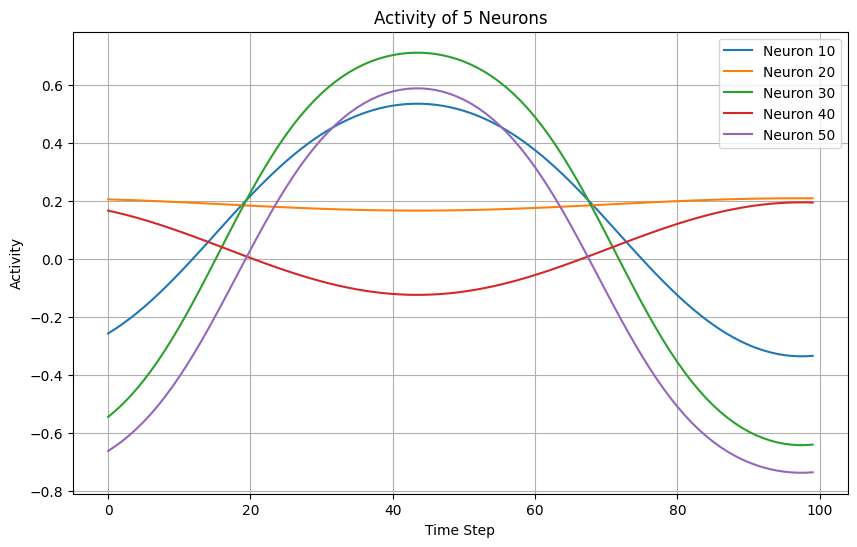

In [7]:
import matplotlib.pyplot as plt

# Create an instance of the dataset
dataset = SineWaveDataset(num_samples=1, seq_length=100, teacher_std=0.1, freq_interval=(MIN_FREQ, MAX_FREQ), phase_interval=(MIN_PHASE, MAX_PHASE))

# Get a sample from the dataset
input_tensor, target_tensor = dataset[0]

# Select 5 neurons to plot
neurons_to_plot = [10, 20, 30, 40, 50] # Example neurons

# Plot the activity of the selected neurons
plt.figure(figsize=(10, 6))
for neuron_index in neurons_to_plot:
    plt.plot(target_tensor[:, neuron_index].cpu().numpy(), label=f"Neuron {neuron_index}")

plt.xlabel("Time Step")
plt.ylabel("Activity")
plt.title("Activity of 5 Neurons")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = normal_rnn(0.1)

    def forward(self, x):
        activity, _ = self.rnn(x)
        return activity

def plot_first_neuron(student, data):
    with torch.no_grad():
        student_output = student(data[0]).to(device)
    plt.figure(figsize=(10, 6))
    plt.plot(data[1][:, 0].cpu().numpy(), label="Teacher")  # Plot teacher's activity for the first neuron
    plt.plot(student_output[:, 0].cpu().numpy(), label="Student") # Plot student's activity for the first neuron

    plt.xlabel("Time Step")
    plt.ylabel("Activity")
    plt.title("Activity of the First Neuron")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [0/1000], Loss: 0.28801763


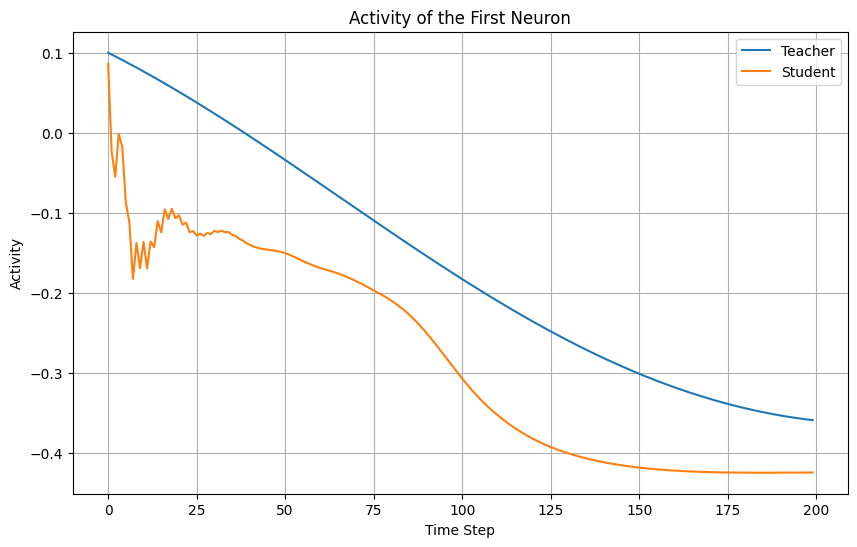

Epoch [10/1000], Loss: 0.01945546
Epoch [20/1000], Loss: 0.00605330
Epoch [30/1000], Loss: 0.00341592
Epoch [40/1000], Loss: 0.00236619


In [ ]:
# Create dataset and dataloader
train_dataset = SineWaveDataset(num_samples=TRAIN_SIZE, seq_length=SEQUENCE_LENGTH, teacher_std=0.1,
                                freq_interval=(MIN_FREQ, MAX_FREQ),
                                phase_interval=(MIN_PHASE, MAX_PHASE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize student model, loss function, and optimizer
student = Student().to(device)
loss_fn = nn.MSELoss()
optimizer = SGD(student.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    total_epoch_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # Forward pass
      outputs = student(inputs)

      # Compute loss
      loss = loss_fn(outputs, targets)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_epoch_loss += loss.item()

    epoch_avg_loss = total_epoch_loss / len(train_loader)
    if epoch % 10 == 0:
      print(f"Epoch [{epoch}/{EPOCHS}], Loss: {epoch_avg_loss:.8f}")
    if epoch % 100 == 0:
      plot_first_neuron(student, train_dataset[0])

print(f"Training finished with loss {epoch_avg_loss:.8f}.")
plot_first_neuron(student, train_dataset[0])

In [ ]:
# Test set parameters
TEST_SIZE = 1000


# Create test datasets
test_dataset = SineWaveDataset(num_samples=TEST_SIZE, seq_length=SEQUENCE_LENGTH, teacher_std=0.1,
                               freq_interval=(MIN_FREQ, MAX_FREQ),
                               phase_interval=(MIN_PHASE, MAX_PHASE))

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) # Create a DataLoader for the test set
total_loss = 0
with torch.no_grad():
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = student(inputs)
    loss = loss_fn(outputs, targets)
    total_loss += loss.item()
loss = total_loss / len(test_loader)

print(f"Generalization Loss: {loss}")
plot_first_neuron(student, test_dataset[0])